In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Specification
Outcomes
- wage, income
- hours worked average and last week
- Unemployed, or out of labor force
- Disability
- Has insurance
    - Insurance coverge by type
- Health status

Treatment
- Year
- State
- Age, below 300% FPL

Controls
- Sex
- Race
- Marital status
- Education

In [137]:
df = pd.read_csv("data/cps.csv")

In [138]:
brief_descriptors = {
    "serial": "id",
    "inclugh": "employer_plan_incl",
    "paidgh": "employer_plan_paid",
    "emcontrb": "employer_contrib",
    "himcaidly": "medicaid",
    "himcarely": "medicare",
    "hichamp": "military_ins",
    "covergh": "group_ins",
    "coverpi": "private_ins",
    "phinsur": "reported_private_ins",
    "phiown": "ins_in_own_name",
    "carely": "medicare_coverage",
    "pmvcaid": "medicaid_value",
    "pmvcare": "medicare_value",
    "ffngcare": "family_medicare_value",
    "ffngcaid": "family_medicaid_value",
    "mocaid": "months_medicaid",
    "verify": "ins_verification",
    "grpdeply": "dep_employer_ins",
    "grptyply": "type_employer_ins",
    "year": "year",
    "statefip": "state",
    "age": "age",
    "sex": "sex",
    "race": "race",
    "marst": "marital_status",
    "educ": "education_level",
    "empstat": "employment_status",
    "labforce": "labor_force_status",
    "uhrsworkt": "usual_hrs_worked",
    "ahrsworkt": "last_wk_hrs_worked",
    "whyunemp": "unemployment_reason",
    "diffany": "any_disability",
    "health": "health_status",
    "quitsick": "quit_due_to_health",
    "incwage": "wage_income",
    "hcovany": "any_insurance",
    "poverty": "below_300_fpl",
}


treatment_variables = [
    "inclugh",
    "paidgh",
    "emcontrb",
    "himcaidly",
    "himcarely",
    "hichamp",
    "covergh",
    "coverpi",
    "phinsur",
    "phiown",
    "carely",
    "pmvcaid",
    "pmvcare",
    "ffngcare",
    "ffngcaid",
    "mocaid",
    "verify",
    "grpdeply",
    "grptyply",
]

df.columns = df.columns.str.lower()

control_variables = ["year", "statefip", "age", "sex", "race", "marst", "educ"]
df["lnearn"] = np.log(df["incwage"]).replace(-np.inf, np.nan)

outcome_variables = [
    "empstat",
    "labforce",
    "uhrsworkt",
    "ahrsworkt",
    "whyunemp",
    "diffany",
    "health",
    "quitsick",
]
df.columns = df.columns.str.lower()

df = df[
    treatment_variables
    + control_variables
    + outcome_variables
    + ["incwage", "hcovany", "poverty", "serial"]
]

df.columns = df.columns.map(brief_descriptors)

In [139]:
df = df[
    [
        "employer_plan_incl",
        "employer_plan_paid",
        "employer_contrib",
        "medicaid",
        "medicare",
        "military_ins",
        "group_ins",
        "private_ins",
        "reported_private_ins",
        "ins_in_own_name",
        "medicare_coverage",
        "medicaid_value",
        "medicare_value",
        "family_medicare_value",
        "family_medicaid_value",
        "months_medicaid",
        "ins_verification",
        "dep_employer_ins",
        "type_employer_ins",
        "year",
        "state",
        "age",
        "sex",
        "race",
        "marital_status",
        "education_level",
        "employment_status",
        "labor_force_status",
        "usual_hrs_worked",
        "last_wk_hrs_worked",
        "unemployment_reason",
        "any_disability",
        "health_status",
        "quit_due_to_health",
        "wage_income",
        "any_insurance",
        "below_300_fpl",
        "id",
    ]
]

In [140]:
cols_mentioned = [
    "wage_income",
    "log_earnings",
    "usual_hrs_worked",
    "last_week_hrs_worked",
    "last_wk_hrs_worked",
    "employment_status",
    "labor_force_status",
    "labor_force",
    "health_status",
    "any_disability",
    "quit_due_to_health",
    "any_insurance",
    "medicaid",
    "medicare",
    "below_300_fpl",
    "below_fpl",
    "between_100_150_fpl",
    "sex",
    "state",
    "mass",
    "race",
    "black",
    "white",
    "education_level",
    "less_than_hs",
    "hs",
    "some_college",
    "college",
    "year",
    "age",
    "id",
]

new = [
    x
    for x in cols_mentioned
    if x
    not in [
        "log_earnings",
        "last_week_hrs_worked",
        "labor_force",
        "below_fpl",
        "between_100_150_fpl",
        "mass",
        "black",
        "white",
        "less_than_hs",
        "hs",
        "some_college",
        "college",
    ]
]

df = df[new]

In [141]:
df["wage_income"] = df["wage_income"].replace({99999999: np.nan, 99999998: np.nan})
df["log_earnings"] = np.log(df["wage_income"].replace({0: np.nan}))
df["usual_hrs_worked"] = df["usual_hrs_worked"].replace({999: np.nan})
df["last_wk_hrs_worked"] = df["last_wk_hrs_worked"].replace({999: np.nan})
df["employment_status"] = df["employment_status"].astype(float).replace({0: np.nan})
df["unemployed"] = (
    (df["employment_status"] >= 20) & (df["employment_status"] < 30)
) * 1
df["labor_force"] = df["labor_force_status"].replace({0: np.nan, 2: 0, 3: 1})
del df["labor_force_status"]
df["good_health"] = df["health_status"] <= 2
df["health_status"] = df["health_status"].astype("str")
df["good_health"] = df["good_health"].replace({True: 1, False: 0})
df["any_disability"] = df["any_disability"].replace({0: np.nan, 1: 0, 2: 1})
df["quit_due_to_health"] = df["quit_due_to_health"].replace({0: np.nan, 1: 0, 2: 1})
df["any_insurance"] = df["any_insurance"].replace({0: np.nan, 1: 0, 2: 1})
df["medicaid"] = df["medicaid"].replace({9: np.nan, 1: 0, 2: 1})
df["medicare"] = df["medicare"].replace({0: np.nan, 1: 0, 2: 1})
df["below_fpl"] = df["below_300_fpl"].replace(
    {
        0: np.nan,
        10: 1,
        20: 0,
        21: 0,
        22: 0,
        23: 0,
    }
)
del df["below_300_fpl"]
df["male"] = (df["sex"] == 1) * 1
# df["state"] = df["state"].replace(
#     {
#         23: "Maine",
#         33: "New Hampshire",
#         50: "Vermont",
#         25: "Massachusetts",
#         44: "Rhode Island",
#         9: "Connecticut",
#     }
# )
df["mass"] = (df["state"] == "Massachusetts") * 1
df["black"] = (df["race"] == 200) * 1
df["white"] = (df["race"] == 100) * 1
# code educ varaible into 4 categories
df["education_level"] = df["education_level"].replace({999: np.nan})
df["less_than_hs"] = (df["education_level"] < 40) * 1
df["hs"] = (df["education_level"] <= 73) * 1
df["some_college"] = (df["education_level"] <= 90) * 1
df["college"] = (df["education_level"] > 90) * 1
del df["education_level"]

### Regression
Basic: any_insurance  = mass + (sum from 2004 to 2001, exclusing 2007)*mass + year FE + state FE


In [142]:
df.columns

Index(['wage_income', 'usual_hrs_worked', 'last_wk_hrs_worked',
       'employment_status', 'health_status', 'any_disability',
       'quit_due_to_health', 'any_insurance', 'medicaid', 'medicare', 'sex',
       'state', 'race', 'year', 'age', 'id', 'log_earnings', 'unemployed',
       'labor_force', 'good_health', 'below_fpl', 'male', 'mass', 'black',
       'white', 'less_than_hs', 'hs', 'some_college', 'college'],
      dtype='object')

In [143]:
df["State_plot"] = df["mass"].map({1: "Massachusetts", 0: "Other States"})
df = df[df["year"] <= 2013]
df["not_insured"] = 1 - df["any_insurance"]
df["low_income"] = df["wage_income"] < 15000  # 25th percentile of wage income for mass
df["mass"] = (df["state"] == "Massachusetts") * 1
df["best_health"] = (df["health_status"].astype(float) <= 1) * 1
df["decent_health"] = (df["health_status"].astype(float) <= 2) * 1
fips_to_state = {
    1: "Alabama",
    2: "Alaska",
    4: "Arizona",
    5: "Arkansas",
    6: "California",
    8: "Colorado",
    9: "Connecticut",
    10: "Delaware",
    11: "District of Columbia",
    12: "Florida",
    13: "Georgia",
    15: "Hawaii",
    16: "Idaho",
    17: "Illinois",
    18: "Indiana",
    19: "Iowa",
    20: "Kansas",
    21: "Kentucky",
    22: "Louisiana",
    23: "Maine",
    24: "Maryland",
    25: "Massachusetts",
    26: "Michigan",
    27: "Minnesota",
    28: "Mississippi",
    29: "Missouri",
    30: "Montana",
    31: "Nebraska",
    32: "Nevada",
    33: "New Hampshire",
    34: "New Jersey",
    35: "New Mexico",
    36: "New York",
    37: "North Carolina",
    38: "North Dakota",
    39: "Ohio",
    40: "Oklahoma",
    41: "Oregon",
    42: "Pennsylvania",
    44: "Rhode Island",
    45: "South Carolina",
    46: "South Dakota",
    47: "Tennessee",
    48: "Texas",
    49: "Utah",
    50: "Vermont",
    51: "Virginia",
    53: "Washington",
    54: "West Virginia",
    55: "Wisconsin",
    56: "Wyoming",
}

df["old_state"] = df["state"]
df["state"] = df["state"].map(fips_to_state)
df.columns

Index(['wage_income', 'usual_hrs_worked', 'last_wk_hrs_worked',
       'employment_status', 'health_status', 'any_disability',
       'quit_due_to_health', 'any_insurance', 'medicaid', 'medicare', 'sex',
       'state', 'race', 'year', 'age', 'id', 'log_earnings', 'unemployed',
       'labor_force', 'good_health', 'below_fpl', 'male', 'mass', 'black',
       'white', 'less_than_hs', 'hs', 'some_college', 'college', 'State_plot',
       'not_insured', 'low_income'],
      dtype='object')

In [152]:
nedf.columns

Index(['wage_income', 'usual_hrs_worked', 'last_wk_hrs_worked',
       'employment_status', 'health_status', 'any_disability',
       'quit_due_to_health', 'any_insurance', 'medicaid', 'medicare', 'sex',
       'state', 'race', 'year', 'age', 'id', 'log_earnings', 'unemployed',
       'labor_force', 'good_health', 'below_fpl', 'male', 'mass', 'black',
       'white', 'less_than_hs', 'hs', 'some_college', 'college', 'State_plot',
       'not_insured', 'low_income', 'old_state', 'best_health',
       'decent_health', 'Massachusetts', 'New Hampshire', 'Rhode Island',
       'Vermont'],
      dtype='object')

In [253]:
nedf

,wage_income,usual_hrs_worked,last_wk_hrs_worked,employment_status,health_status,any_disability,quit_due_to_health,any_insurance,medicaid,medicare,...,mass_2004,mass_2005,mass_2006,mass_2007,mass_2008,mass_2009,mass_2010,mass_2011,mass_2012,mass_2013
1353,60000.0,45.0,45.0,10.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1354,61400.0,NaN,NaN,21.0,3.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1355,0.0,997.0,NaN,12.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1356,0.0,997.0,NaN,12.0,4.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1357,10384.0,28.0,22.0,10.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670843,0.0,NaN,NaN,34.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2670844,75000.0,45.0,45.0,10.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2670845,0.0,NaN,NaN,34.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2670846,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [257]:
nedf[
    (nedf["state"] == "Massachusetts")
    & (nedf["year"] == 2006)
    & (nedf["any_insurance"].notna())
]["any_insurance"].mean()

0.9214402618657938

In [ ]:
nedf[""]

In [237]:
def run_event_study(data, y_var, exclude_year=2007, include_constant=True):
    # Create interaction terms for 'mass' with each year, excluding 2007
    for year in range(2001, 2014):
        if year != exclude_year:  # Skip 2007
            data[f"mass_{year}"] = data["mass"] * (data["year"] == year)

    # Define the formula for the event study
    terms = " + ".join(
        [f"mass_{year}" for year in range(2001, 2014) if year != exclude_year]
    )
    formula = f"{y_var} ~ " + terms if include_constant else f"{y_var} ~ -1 + " + terms

    # Add year fixed effects
    formula += " + C(year)"

    # Add state fixed effects
    formula += " + C(state) + C(id)"

    # print(formula)

    # Run the regression
    model = smf.ols(formula, data=data).fit(
        cov_type="cluster", cov_kwds={"groups": data["state"]}
    )
    return model


def plot_event_study(
    model_results,
    start_year=2001,
    end_year=2013,
    exclude_year=2007,
    impl_start=2005.5,
    impl_end=2007.5,
    y="",
):
    years = [y for y in range(start_year, end_year + 1)]
    coeffs = [model_results.params.get(f"mass_{y}", 0) for y in years]
    conf_ints = [
        (
            model_results.conf_int().loc[f"mass_{y}"]
            if f"mass_{y}" in model_results.conf_int().index
            else (0, 0)
        )
        for y in years
    ]

    errors = [
        (ci[1] - ci[0]) / 2 for ci in conf_ints
    ]  # Compute symmetric errors as half the confidence interval width

    plt.figure(figsize=(12, 6))  # Make plot wider
    plt.errorbar(
        years,
        coeffs,
        yerr=errors,
        fmt="o",
        color="black",
        ecolor="black",
        elinewidth=3,
        capsize=5,
        capthick=2,
        label="Estimated Coefficient ± 95% CI",
    )

    # Mark the excluded year with a distinct dot and ensure it's part of the x-axis
    if exclude_year in years:
        plt.plot(
            exclude_year,
            model_results.params.get(f"mass_{exclude_year}", 0),
            "ro",
            label="Excluded Year",
            color="black",
        )

    plt.axvline(x=impl_start, color="grey", linestyle="--", linewidth=2, alpha=0.5)
    plt.axvline(x=impl_end, color="grey", linestyle="--", linewidth=2, alpha=0.5)

    plt.axhline(0, color="black", linestyle="-", linewidth=2)
    plt.xticks(years, rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Coefficient")
    plt.title("Event Study Plot: Impact of Massachusetts Healthcare Reform on " + y)
    plt.legend()
    plt.grid(True)
    plt.show()


# ne = ["Massachusetts", "New Hampshire", "Connecticut", "Rhode Island", "Maine", "Vermont", "Pennsylvania"]
ne = ["Massachusetts", "New Hampshire", "Rhode Island", "Vermont"]
nedf = df[df["state"].isin(ne)]
for state in ne:
    nedf[state] = (nedf["state"] == state) * 1
young = nedf[(nedf["age"] >= 18) & (nedf["age"] <= 26)]
low_income = nedf[nedf["wage_income"] < 15000]
no_insurance = nedf[nedf["any_insurance"] == 0]
below_fpl = nedf[nedf["below_fpl"] == 1]
male = nedf[nedf["male"] == 1]
black = nedf[nedf["black"] == 1]


for outcome in [
    "not_insured",
    # "last_wk_hrs_worked",
    # "good_health",
    # "decent_health",
    # "best_health",
    # "unemployed",
]:
    for group, i in zip(
        [nedf],  # , young, low_income, no_insurance, below_fpl]
        ["overall", "young", "low_income", "no_insurance", "below_fpl"],
    ):
        try:
            result = run_event_study_linearmodels(
                group[group[outcome].notna()], outcome
            )
            print(outcome)
            print(i)
            plot_event_study(result, y=outcome)
        except:
            print("skip")
            pass


# nedf = df[df["state"].isin(ne)]
# young = young[young["state"].isin(ne)]
# # low_income = df[(df["wage_income"] < 10000) & (df["wage_income"]>0)]
# low_income = low_income[low_income["state"].isin(ne)]
# no_insurance = no_insurance[no_insurance["state"].isin(ne)]

# hm = df[df["state"].isin(ne)]
# hm = hm[hm["below_fpl"] == 1]

# result = run_event_study(hm, "any_insurance")
# print(result.summary())
# plot_event_study(result)

skip


In [154]:
from linearmodels.panel import PanelOLS

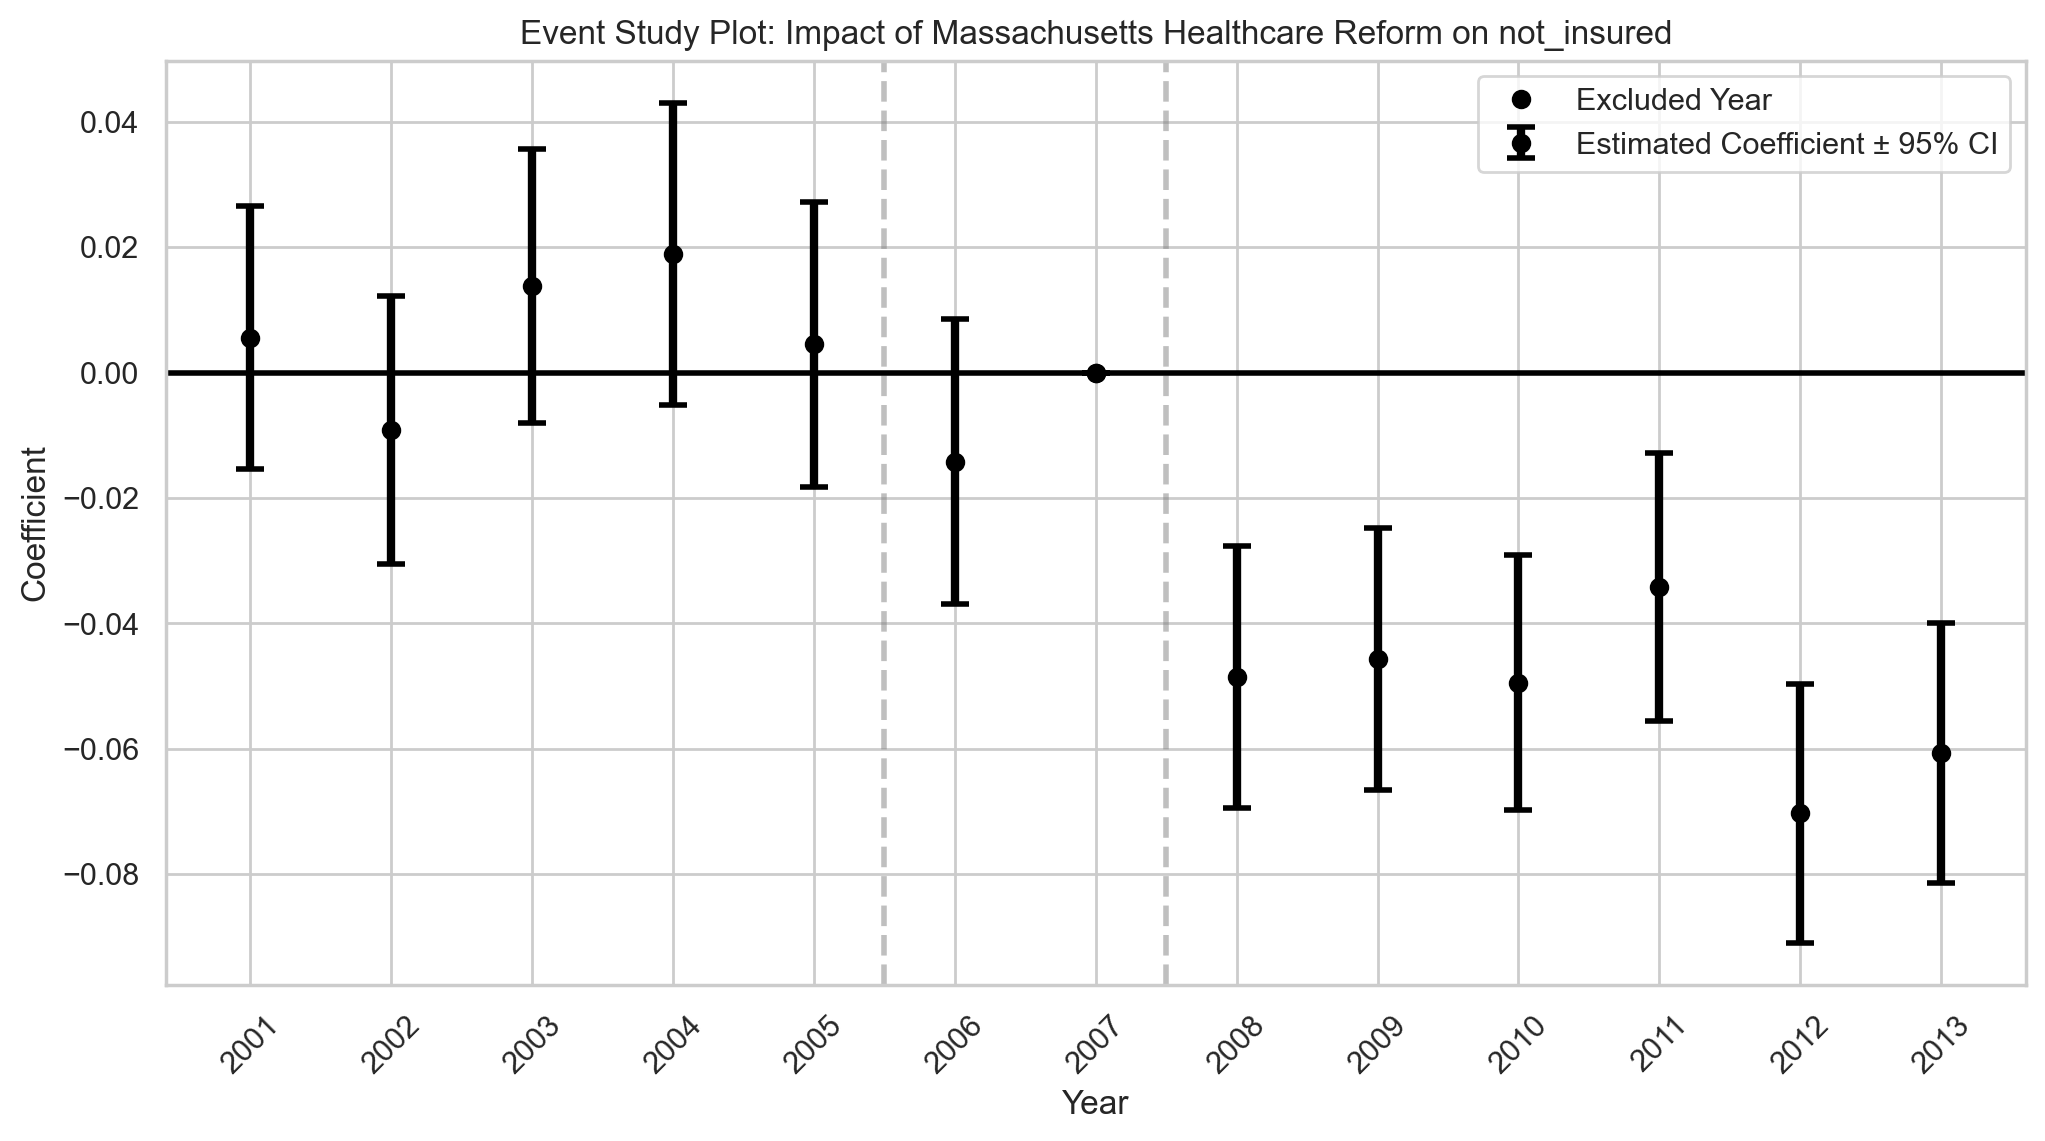

In [249]:
for yr in range(2001, 2014):
    nedf["mass_" + str(yr)] = nedf["mass"] * (nedf["year"] == yr)


def run_event_study_linearmodels(
    data, y_var, exclude_year=2007, include_constant=False, ne=ne
):
    data = data.copy()
    data = data[[y_var, "id", "year"] + ne + ["state"]]
    data["mass"] = (data["state"] == "Massachusetts") * 1
    for yr in range(2001, 2014):
        data["mass_" + str(yr)] = data["mass"] * (nedf["year"] == yr)
    data = data.set_index(["id", "year"])  # Set the multi-index for panel data
    exog_vars = [
        f"mass_{year}" for year in range(2001, 2014) if year != exclude_year
    ] + [x for x in ne if x != "Massachusetts"]
    exog = data[exog_vars]
    if include_constant:
        exog["const"] = 1  # Add a constant term manually if needed
    endog = data[y_var]

    # Define the model with state and year fixed effects
    model = PanelOLS(endog, exog, entity_effects=True, time_effects=True)

    fitted_model = model.fit(cov_type="clustered", cluster_entity=True)

    return fitted_model


run_event_study_linearmodels(nedf, "not_insured")
plot_event_study(run_event_study_linearmodels(nedf, "not_insured"), y="not_insured")

In [250]:
run_event_study_linearmodels(nedf, "not_insured")

Dep. Variable:,not_insured,R-squared:,0.0021
Estimator:,PanelOLS,R-squared (Between):,-0.1819
No. Observations:,180839,R-squared (Within):,0.0012
Date:,"Sat, Mar 30 2024",R-squared (Overall):,-0.0414
Time:,21:12:13,Log-likelihood,-1.633e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,24.352
Entities:,7563,P-value,0.0000
Avg Obs:,23.911,Distribution:,"F(15,173248)"
Min Obs:,1.0000,,
Max Obs:,59.000,F-statistic (robust):,12.624


In [214]:
nedf

,wage_income,usual_hrs_worked,last_wk_hrs_worked,employment_status,health_status,any_disability,quit_due_to_health,any_insurance,medicaid,medicare,...,mass_2005,mass_2006,mass_2007,mass_2008,mass_2009,mass_2010,mass_2011,mass_2012,mass_2013,work
1353,60000.0,45.0,45.0,10.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1354,61400.0,NaN,NaN,21.0,3.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1355,0.0,997.0,NaN,12.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1356,0.0,997.0,NaN,12.0,4.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1357,10384.0,28.0,22.0,10.0,2.0,NaN,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670843,0.0,NaN,NaN,34.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2670844,75000.0,45.0,45.0,10.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2670845,0.0,NaN,NaN,34.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2670846,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [239]:
for year in range(2001, 2014):
    nedf["mass_" + str(year)] = nedf["mass"] * (nedf["year"] == year)

In [241]:
def plot_event_study_comparison(
    model_results1,
    model_results2,
    start_year=2001,
    end_year=2013,
    exclude_year=2007,
    impl_start=2005.5,
    impl_end=2007.5,
    y="",
    label1="Model 1",
    label2="Model 2",
    title="Income Terciles",
):
    plt.figure(figsize=(12, 6))
    offset = 0.1  # Define an offset to separate the error bars
    years = [y for y in range(start_year, end_year + 1)]

    for model_results, ecolor, direction in zip(
        [model_results1, model_results2], ["grey", "black"], [-offset, offset]
    ):
        coeffs = [model_results.params.get(f"mass_{y}", 0) for y in years]
        conf_ints = [
            (
                model_results.conf_int().loc[f"mass_{y}"]
                if f"mass_{y}" in model_results.conf_int().index
                else (0, 0)
            )
            for y in years
        ]
        errors = [(ci[1] - ci[0]) / 2 for ci in conf_ints]

        # Shift years for each model to prevent overlap
        adjusted_years = [year + direction for year in years]

        plt.errorbar(
            adjusted_years,
            coeffs,
            yerr=errors,
            fmt="o",
            color=ecolor,
            ecolor=ecolor,
            elinewidth=3,
            capsize=5,
            capthick=2,
            label=f"{label1 if ecolor == 'grey' else label2}: Coefficient ± 95% CI",
        )

    plt.axvline(x=impl_start, color="grey", linestyle="--", linewidth=2, alpha=0.5)
    plt.axvline(x=impl_end, color="grey", linestyle="--", linewidth=2, alpha=0.5)
    plt.axhline(0, color="black", linestyle="-", linewidth=2)
    plt.xticks(years, rotation=45)
    plt.xlabel("Year")
    plt.ylabel("Coefficient")
    plt.title(
        f"Impact of the Massachusetts Healthcare Reform on Healthcare Coverage by {title}"
    )
    plt.legend()
    plt.grid(True)
    plt.show()


high_income = nedf[nedf["wage_income"] > 30000]
low_income = nedf[nedf["wage_income"] < 15000]
model1 = run_event_study_linearmodels(high_income, "not_insured")
model2 = run_event_study_linearmodels(low_income, "not_insured")
plot_event_study_comparison(
    model1,
    model2,
    y="not_insured",
    label1="Top Income Tercile",
    label2="Bottom Income Tercile",
)

KeyError: "['mass_2001', 'mass_2002', 'mass_2003', 'mass_2004', 'mass_2005', 'mass_2006', 'mass_2008', 'mass_2009', 'mass_2010', 'mass_2011', 'mass_2012', 'mass_2013'] not in index"

In [244]:
nedf.columns

Index(['wage_income', 'usual_hrs_worked', 'last_wk_hrs_worked',
       'employment_status', 'health_status', 'any_disability',
       'quit_due_to_health', 'any_insurance', 'medicaid', 'medicare', 'sex',
       'state', 'race', 'year', 'age', 'id', 'log_earnings', 'unemployed',
       'labor_force', 'good_health', 'below_fpl', 'male', 'mass', 'black',
       'white', 'less_than_hs', 'hs', 'some_college', 'college', 'State_plot',
       'not_insured', 'low_income', 'old_state', 'best_health',
       'decent_health', 'mass_post', 'Massachusetts', 'New Hampshire',
       'Rhode Island', 'Vermont', 'mass_2001', 'mass_2002', 'mass_2003',
       'mass_2004', 'mass_2005', 'mass_2006', 'mass_2007', 'mass_2008',
       'mass_2009', 'mass_2010', 'mass_2011', 'mass_2012', 'mass_2013'],
      dtype='object')

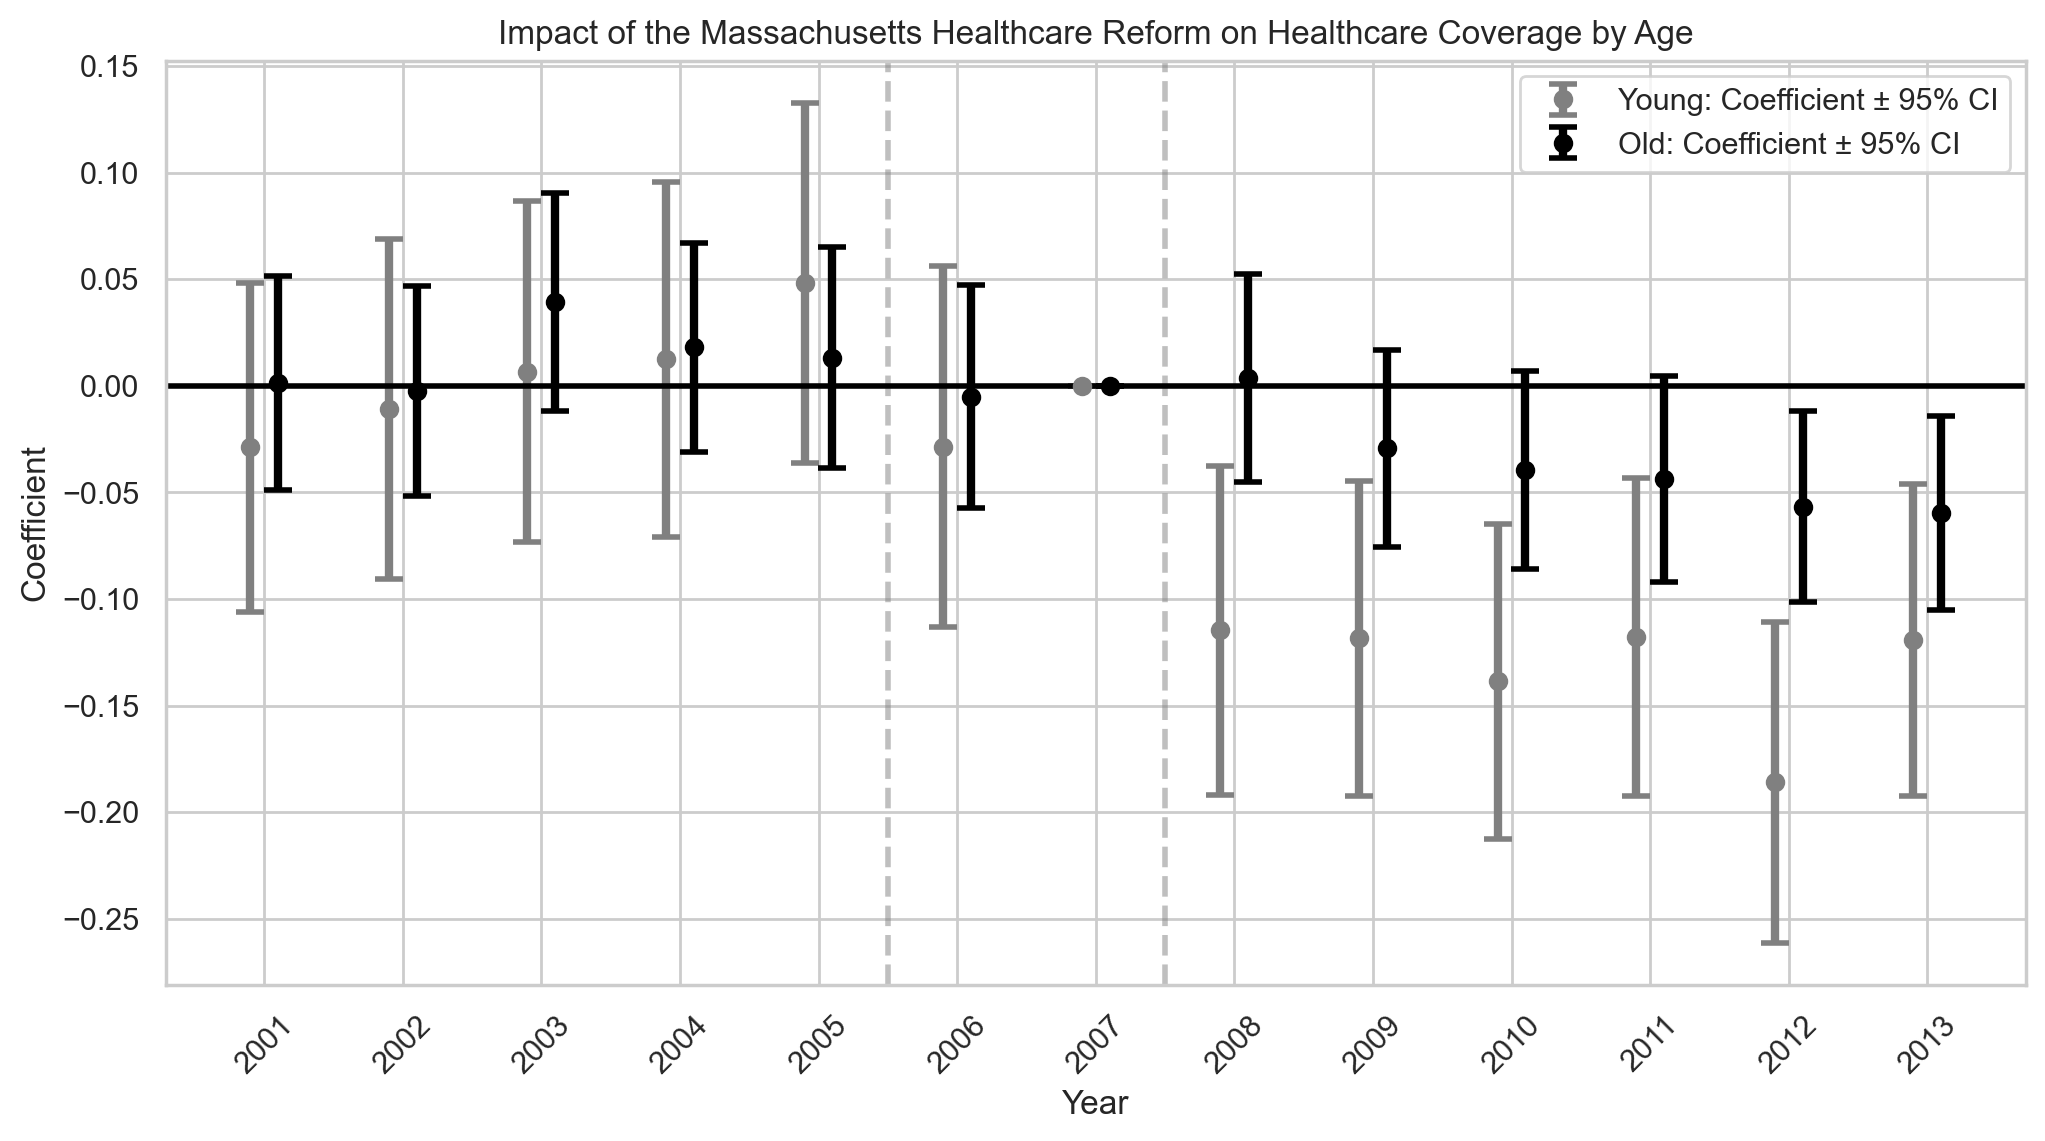

In [246]:
young = nedf[(nedf["age"] >= 18) & (nedf["age"] <= 30)]
old = nedf[(nedf["age"] >= 50) & (nedf["age"] <= 64)]
model1 = run_event_study_linearmodels(young, "not_insured")
model2 = run_event_study_linearmodels(old, "not_insured")
plot_event_study_comparison(
    model1, model2, y="not_insured", label1="Young", label2="Old", title="Age"
)

In [248]:
model2

Dep. Variable:,not_insured,R-squared:,0.0022
Estimator:,PanelOLS,R-squared (Between):,-0.0793
No. Observations:,30006,R-squared (Within):,-0.0003
Date:,"Sat, Mar 30 2024",R-squared (Overall):,-0.0374
Time:,21:11:08,Log-likelihood,2178.0
Cov. Estimator:,Clustered,,
,,F-statistic:,3.4809
Entities:,6778,P-value,0.0000
Avg Obs:,4.4270,Distribution:,"F(15,23200)"
Min Obs:,1.0000,,
Max Obs:,16.000,F-statistic (robust):,2.5875


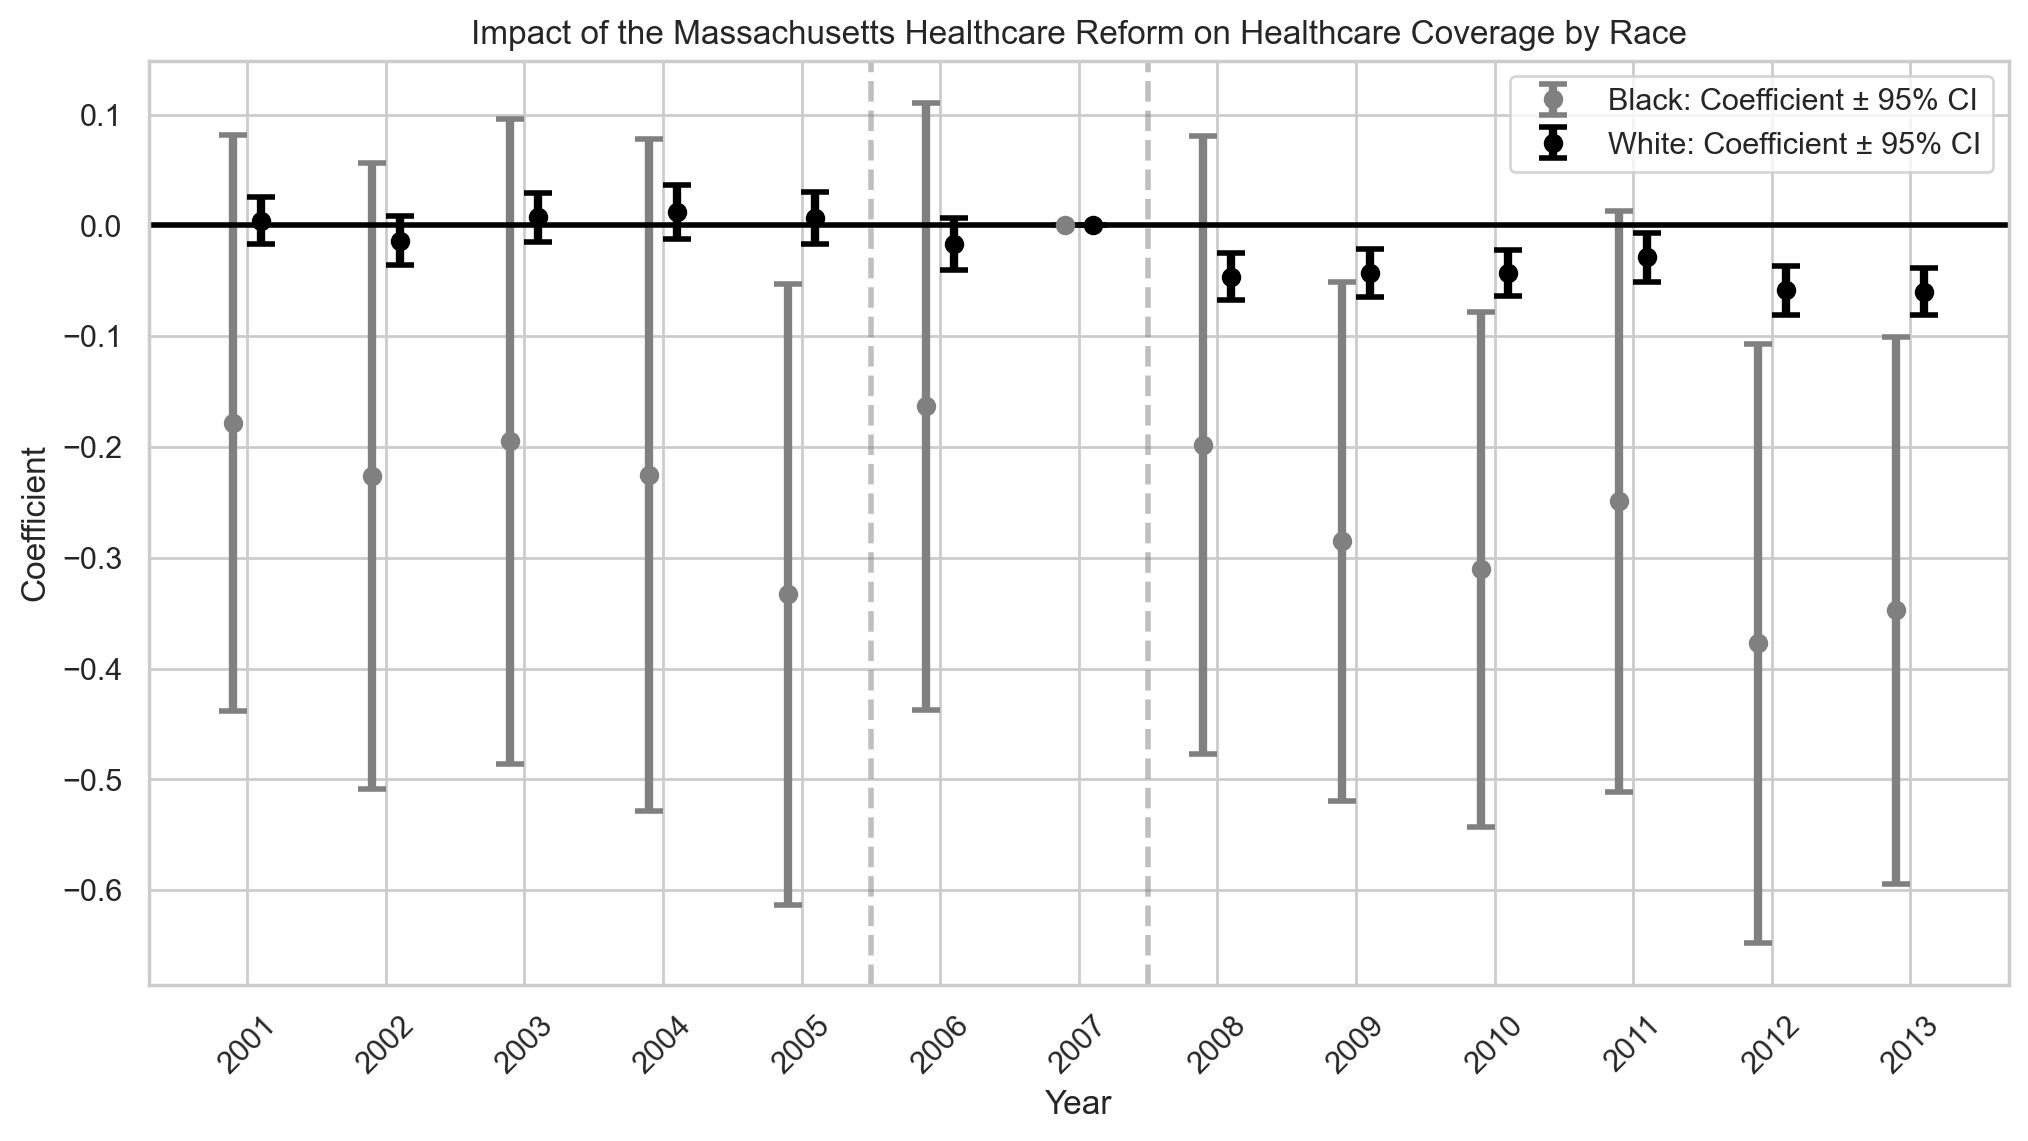

In [236]:
### INCOME
# model1
model1.summary().as_latex()

TypeError: 'Summary' object is not callable

In [189]:
model2

Dep. Variable:,not_insured,R-squared:,0.0051
Estimator:,PanelOLS,R-squared (Between):,-0.2389
No. Observations:,30312,R-squared (Within):,0.0013
Date:,"Sat, Mar 30 2024",R-squared (Overall):,-0.1131
Time:,20:37:23,Log-likelihood,-7214.0
Cov. Estimator:,Clustered,,
,,F-statistic:,8.0359
Entities:,6955,P-value,0.0000
Avg Obs:,4.3583,Distribution:,"F(15,23329)"
Min Obs:,1.0000,,
Max Obs:,16.000,F-statistic (robust):,5.7702


In [183]:
income_comp["wage_income"].quantile(0.66666)

43750.42063999997

In [184]:
nedf.columns
nedf["work"] = (nedf["wage_income"] > 0) * 1
income_comp = nedf[nedf["work"] == 1]
low_income = income_comp[income_comp["wage_income"] < 20000]
high_income = income_comp[income_comp["wage_income"] >= 43750.42063999997]

In [216]:
nedf["State_plot"] = nedf["mass"].map({1: "Massachusetts", 0: "Other States"})

In [221]:
nedf["state"].value_counts()

New Hampshire    50970
Massachusetts    46825
Rhode Island     45586
Vermont          37458
Name: state, dtype: int64

In [227]:
nedf["mass"] = (nedf["state"] == "Massachusetts") * 1

In [226]:
nedf["State_label"] = 

0    180839
Name: mass, dtype: int64

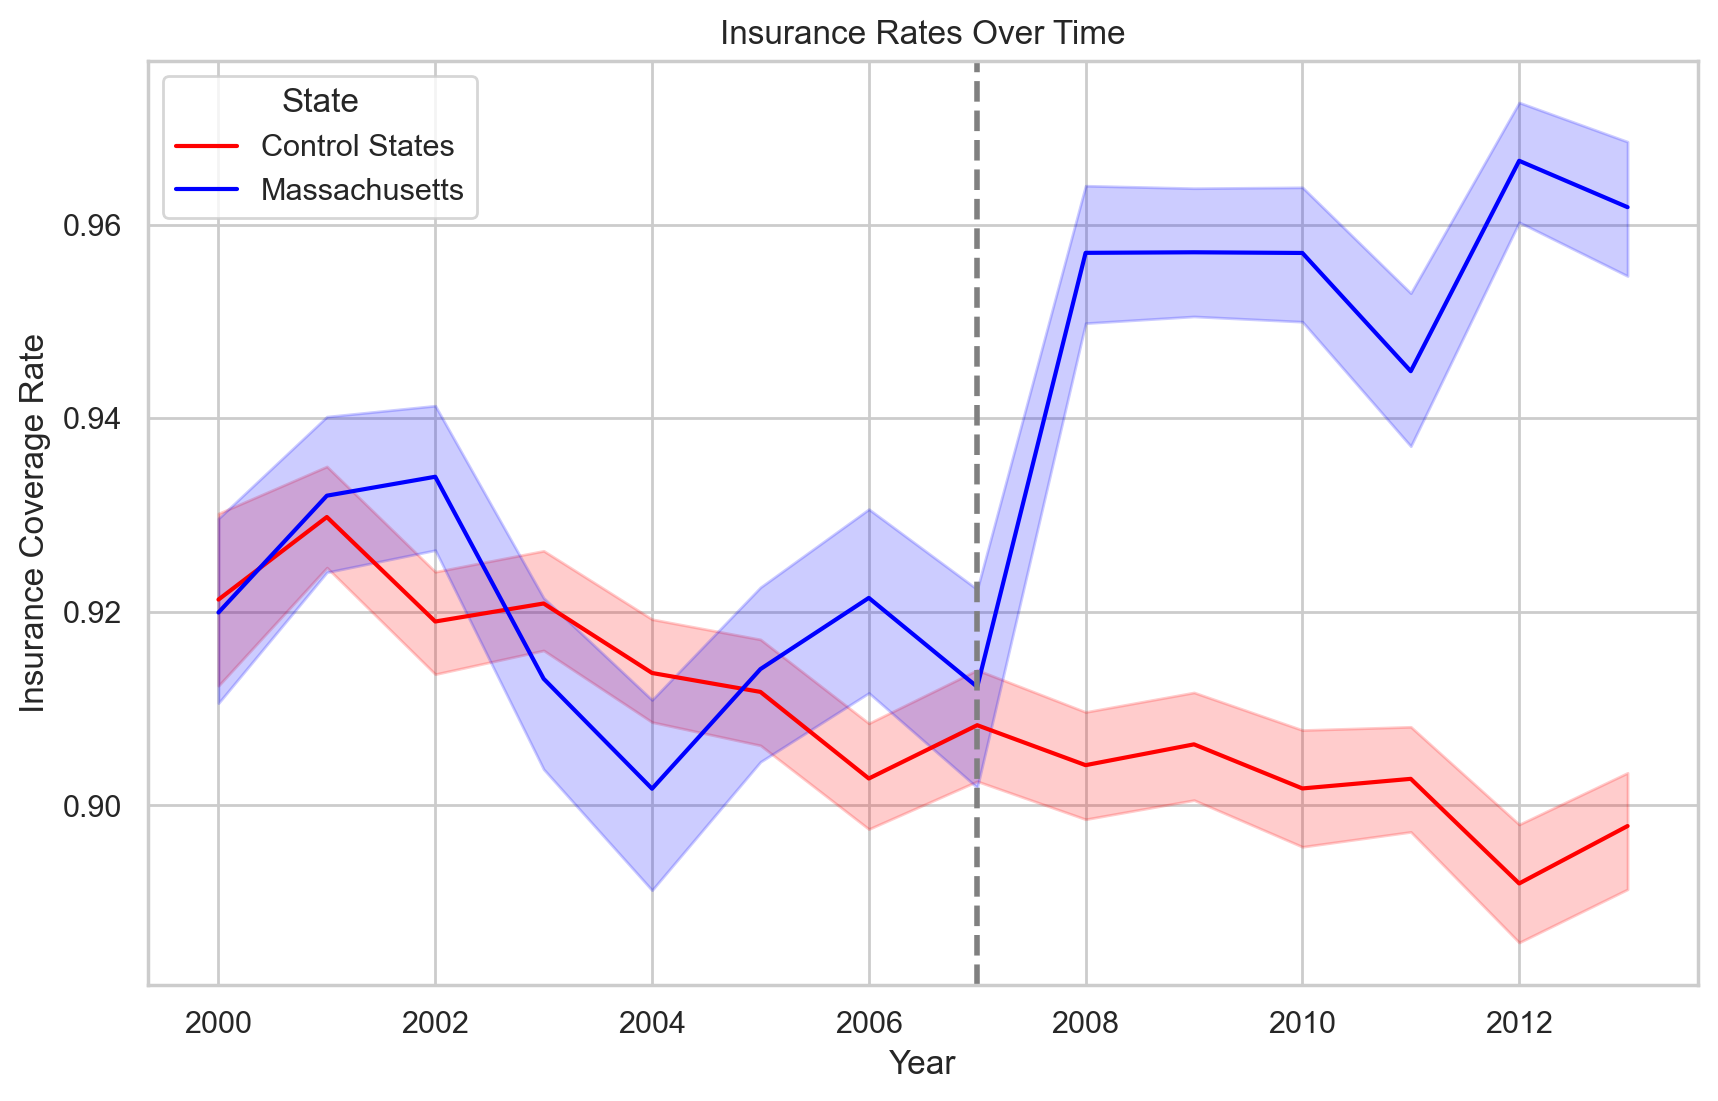

In [232]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_event(y):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    lineplot = sns.lineplot(
        x="year", y=y, data=nedf, hue="mass", palette=["red", "blue"]
    )
    plt.axvline(
        x=2007, color="grey", linestyle="--", linewidth=2
    )  # Add vertical line at 2007
    plt.xlabel("Year")
    plt.ylabel(y)
    # Customizing the legend
    hand, labl = lineplot.get_legend_handles_labels()
    plt.legend(hand, ["Control States", "Massachusetts"], title="State")
    plt.title("Insurance Rates Over Time")
    plt.ylabel("Insurance Coverage Rate")
    plt.show()


plot_event("any_insurance")

## Synthetic Control

In [ ]:
df.head()
# compute mean

,wage_income,usual_hrs_worked,last_wk_hrs_worked,employment_status,health_status,any_disability,quit_due_to_health,any_insurance,medicaid,medicare,...,good_health,below_fpl,male,mass,black,white,less_than_hs,hs,some_college,college
0,44600.0,48.0,47.0,10.0,1.0,NaN,0.0,1.0,0.0,0.0,...,1,0.0,0,0,0,1,0,0,0,1
1,2000.0,10.0,10.0,10.0,1.0,NaN,0.0,1.0,0.0,0.0,...,1,0.0,1,0,0,1,0,1,1,0
2,0.0,NaN,NaN,36.0,5.0,NaN,0.0,1.0,0.0,1.0,...,0,0.0,0,0,0,1,0,0,1,0
3,12000.0,43.0,43.0,10.0,0.0,NaN,0.0,1.0,0.0,0.0,...,1,0.0,1,0,0,1,0,0,1,0
4,20000.0,39.0,36.0,10.0,3.0,NaN,0.0,1.0,0.0,0.0,...,0,0.0,0,0,0,1,0,1,1,0
